In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from mnist import MNIST
from sklearn import manifold
import numpy as np
import os
from matplotlib import offsetbox
from torch.utils.tensorboard import SummaryWriter

In [ ]:
## Loading Model ##

from model_class import AutoEncoder
load_dir  = "./checkpoints/"

model = AutoEncoder()

try:
    load_ckpt_num = 68
    checkpoint = torch.load(load_dir+"/ep_{}.ckpt".format(load_ckpt_num))
    model.load_state_dict(checkpoint['model_state_dict'])
    global_epoch = checkpoint['global_epoch']
    print("loaded global ep: {}".format(global_epoch))
except Exception as e:
    print("Loading checkpoint failed! - {}".format(e))
    global_epoch = 0

In [ ]:
## Loading Data

mndata = MNIST('Data/mnist')
raw_train_images, raw_train_labels = mndata.load_training()
raw_test_images, raw_test_labels = mndata.load_testing()

X_tr = np.array(raw_train_images)
y_tr = np.array(raw_train_labels)
X_te = np.array(raw_test_images)
y_te = np.array(raw_test_labels)

X_tr_imgs = X_tr.reshape([-1, 1,28,28])
X_te_imgs = X_te.reshape([-1, 1,28,28])


print("X_tr: {}".format(X_tr.shape))
print("y_tr: {}".format(y_tr.shape))
print("X_te: {}".format(X_te.shape))
print("y_te: {}".format(y_te.shape))
print("X_tr_imgs: {}".format(X_tr_imgs.shape))
print("X_te_imgs: {}".format(X_te_imgs.shape))

In [ ]:
def display_img(tensor):
    m = tensor.shape[0]
    for i in range(m):
        temp = tensor[i].permute(1,2,0).detach().numpy()
        plt.imshow(temp, cmap='gray')
        plt.show()


In [ ]:
# out = model.forward(torch.tensor(X_te_imgs)/255)
# out.shape

# writer    = SummaryWriter('runs/embd')
# temp = out.reshape([-1,1*28*28])
# l = torch.tensor(X_te_imgs)
# print(temp.shape)
# print(list(y_te[:5]))
# print(X_te_imgs[:5].shape)
# writer.add_embedding(temp,
#                       metadata=list(y_te),
#                       label_img=l
#                      )

In [ ]:
# l_out = model.encoder(torch.tensor(X_te_imgs)/255)
# print(l_out.shape)

# writer    = SummaryWriter('runs/embd_latent')

# l = torch.tensor(X_te_imgs)
# writer.add_embedding(l_out,
#                       metadata=list(y_te),
#                       label_img=l
#                      )

In [ ]:
rule = y_te==2
x_rule = X_te_imgs[rule]
len(x_rule)

In [ ]:
## Taking a single image & averaging the latent outputs
rule_1 = y_te==7
rule_2 = y_te==9

a = torch.tensor(X_te_imgs[rule_1][:1])/255
b = torch.tensor(X_te_imgs[rule_2][:1])/255


with torch.no_grad():
    l1 = model.encoder(a)
    l2 = model.encoder(b)
    l_avg = (l1+l2)/2

    o1 = model.decoder(l1)
    o2 = model.decoder(l2)
    o3 = model.decoder(l_avg)

    display_img(o1)
    display_img(o2)
    display_img(o3)

In [ ]:
# Taking all the images of those particular labels
# Finding the corresponding latent vectors for all the images
# Taking the mean/median of latent vectors
# Plotting the weighted average of mean_latent vectors.
# Also, Finding mse b/w the 2 mean_latent vectors


rule_1 = y_te==7
rule_2 = y_te==1

a = torch.tensor(X_te_imgs[rule_1])/255
b = torch.tensor(X_te_imgs[rule_2])/255

mse = torch.nn.MSELoss()

with torch.no_grad():
    l1 = model.encoder(a)
    l2 = model.encoder(b)
    
    print(l1.shape)
    print(l2.shape)
    
    l1_mean = l1.mean(axis=0)
    l2_mean = l2.mean(axis=0)
    print(l1_mean.shape)
    print(l2_mean.shape)
    
    mse_val = mse(l1_mean, l2_mean)
    print("mse: ", mse_val.item())
    
    w = 0.4
    l_avg = (w*l1_mean + (1-w)*l2_mean)

    o1 = model.decoder(l1_mean)
    o2 = model.decoder(l2_mean)
    o3 = model.decoder(l_avg)

    display_img(o1)
    display_img(o2)
    display_img(o3)

torch.Size([700, 10])


torch.Size([5000, 10])
Computing t-SNE embedding


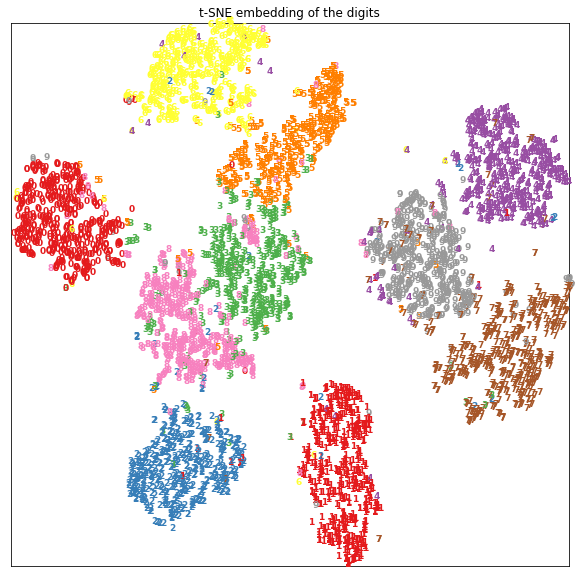

In [28]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

N=5000
input_700 = torch.tensor(X_tr_imgs[:N])/255
with torch.no_grad():
    l700 = model.encoder(input_700)
    print(l700.shape)
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(l700)
plot_embedding(X_tsne, y_tr[:N],
               "t-SNE embedding of the digits")